# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash
pip install -U lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library.

```bash
pip install lida[transformers]
```

## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset.

### Multiple LLM Backends
LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `text_gen` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python

from lida import llm

text_gen = llm("openai") # for openai
text_gen = llm(provider="openai", api_type="azure", azure_endpoint=os.environ["AZURE_OPENAI_BASE"], api_key=os.environ["AZURE_OPENAI_API_KEY"],    api_version="2023-07-01-preview") # for azure openai
text_gen = llm("cohere") # for cohere
text_gen = llm("palm") # for palm
text_gen = llm(provider="hf", model="uukuguy/speechless-llama2-hermes-orca-platypus-13b", device_map="auto")

lida = Manager(text_gen=text_gen)
```

Note that you can set your llm keys as follows

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```
#### Azure OpenAI
```python
from llmx import  llm, TextGenerationConfig
import os

text_gen = llm(
    provider="openai",
    api_type="azure",
    azure_endpoint=os.environ["AZURE_OPENAI_BASE"],
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    api_version="2023-07-01-preview",
)
lida = Manager(text_gen=text_gen)
```


### Summarization Methods
The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm.

### Caching
Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.


In [2]:
from lida import Manager, TextGenerationConfig , llm

## Summarize Data, Generate Goals

In [3]:
text_gen = llm(
    provider="openai",
    api_type="azure",
    azure_endpoint="https://wechatgpt.openai.azure.com/",
    api_key="ae0807d1c48146c38ff998c9abf9b7cc",
    api_version="2024-02-01",
)
lida = Manager(text_gen=text_gen)

In [4]:
# lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-4o", use_cache=True)

summary = lida.summarize("/home/chris/repo/autogen/ice_cream_sales_data.csv", summary_method="default", textgen_config=textgen_config)
goals = lida.goals(summary, n=2, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** How do ice cream sales volumes vary over time?

**Visualization:** `line chart of 'sell_time' vs. 'sell_volume'`

**Rationale:** Plotting 'sell_time' on the x-axis and 'sell_volume' on the y-axis will help us identify trends and patterns in sales over time. This can provide insights into seasonality, peak sales periods, and any anomalies in the data.



### Goal 1
---
**Question:** Which product SKUs have the highest sales volumes?

**Visualization:** `bar chart of 'product_sku' vs. sum of 'sell_volume'`

**Rationale:** By aggregating 'sell_volume' by 'product_sku' and displaying it in a bar chart, we can easily compare the sales performance of different products. This will help identify the most popular products and inform inventory and marketing strategies.


In [5]:
# goals can also be based on a persona
persona = "a sale manager who wants to stock up ice creams that is popular"
personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)
for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** Which ice cream products have the highest sell volume?

**Visualization:** `bar chart of 'product_sku' vs. sum of 'sell_volume'`

**Rationale:** By plotting the sum of 'sell_volume' for each 'product_sku', the sales manager can identify which ice cream products are the most popular and should be stocked up more frequently. This information is crucial for inventory management and ensuring that high-demand products are always available.



### Goal 1
---
**Question:** How does the sell volume vary by freezer location?

**Visualization:** `bar chart of 'freezer' vs. sum of 'sell_volume'`

**Rationale:** By visualizing the sum of 'sell_volume' for each 'freezer', the sales manager can determine which freezer locations are performing better in terms of sales. This insight can help in optimizing the placement of ice cream products and improving overall sales performance by focusing on high-performing locations.


## Generate Visualizations

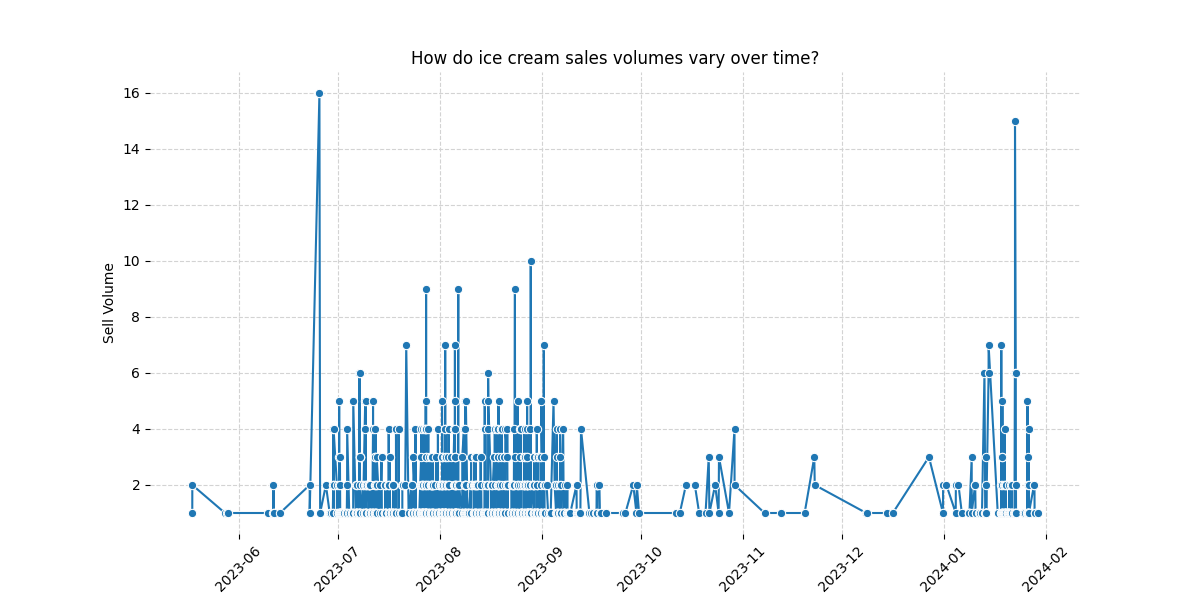

In [6]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)
charts[0]

### Generate visualization via a "user query"   

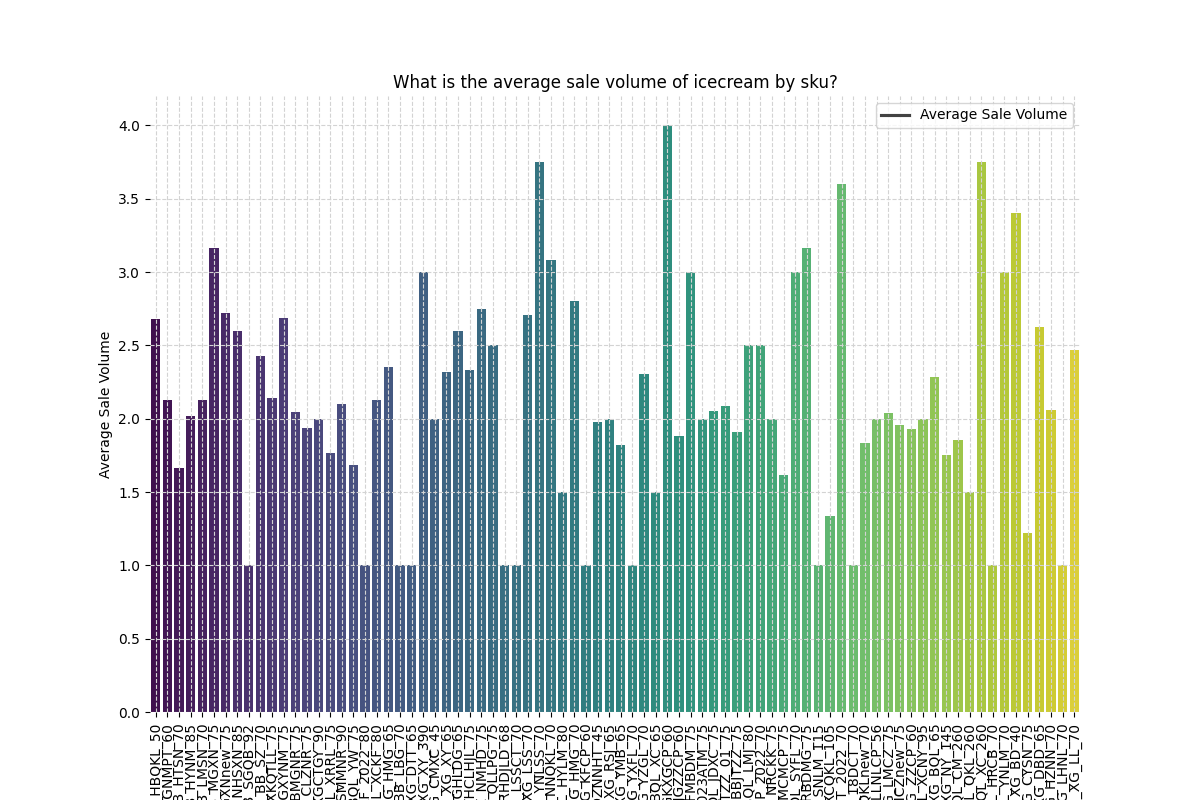

In [7]:
warnings.filterwarnings('ignore', category=UserWarning)



user_query = "What is the average sale volume of icecream by sku?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)
charts[0]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation.

This includes
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

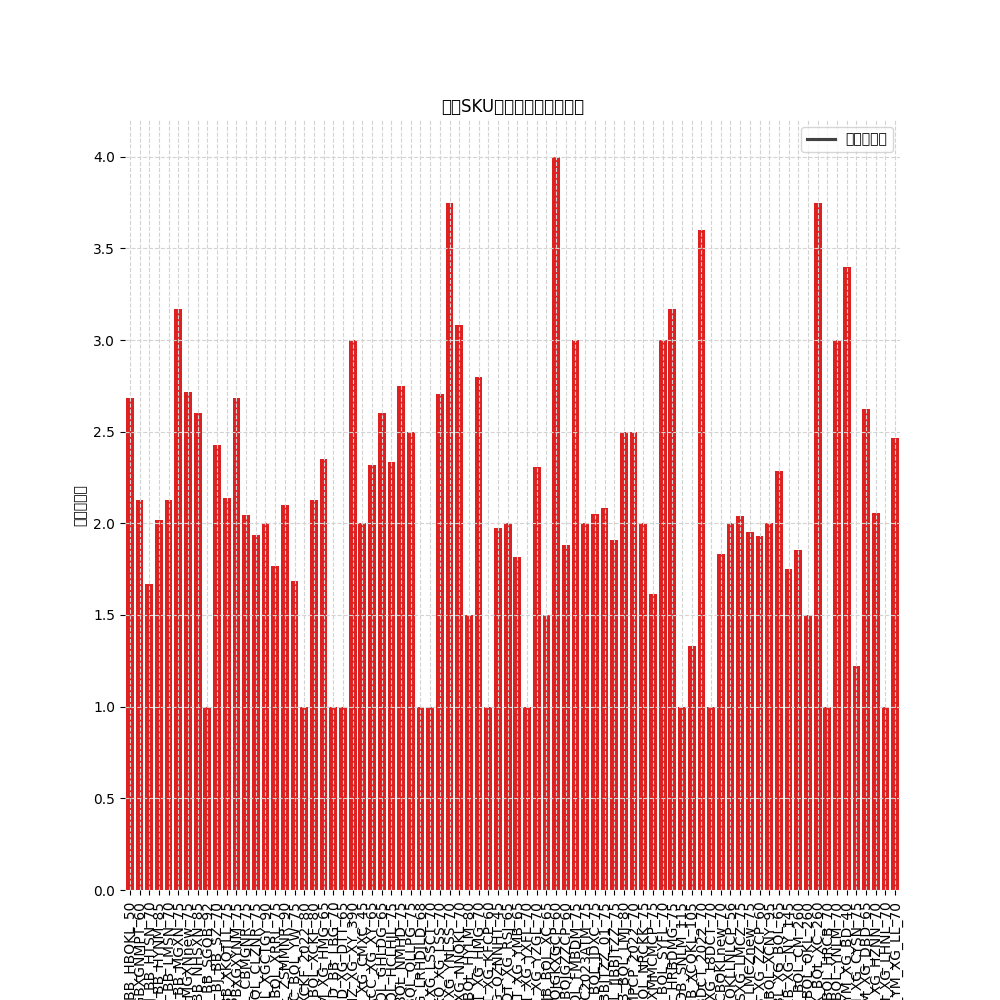

In [8]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["make the chart height and width equal", "change the color of the chart to red", "translate the chart to Chinese"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
edited_charts[0]

## Visualization explanations and accessibility

In [9]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config)
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The chart is a bar plot with 'product_sku' on the x-axis and the average 'sell_volume' on the y-axis. The bars are colored using the 'viridis' palette, which provides a visually appealing gradient. The x-axis labels are rotated 90 degrees to ensure they are legible. The chart includes a title 'What is the average sale volume of icecream by sku?' and labels for both axes. A legend is also added to indicate that the bars represent the average sale volume.
transformation  **  First, the 'sell_time' column is converted to datetime format, and any invalid dates are coerced to NaT (Not a Time). Rows with NaT values in the 'sell_time' column are then removed. Next, the data is grouped by 'product_sku', and the average 'sell_volume' for each SKU is calculated. The result is stored in a new DataFrame called 'avg_sell_volume'.
visualization  **  A figure is created with a size of 12x8 inches. A bar plot is then created using Seaborn's barplot function, with 'product_sku' on th

## Visualization code self-evaluation and repair

In [10]:
evaluations = lida.evaluate(code=code,  goal=goals[i], textgen_config=textgen_config, library=library)[0]
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 4 / 10
	 The code does not contain syntax errors, but it fails to address the specified goal of showing how ice cream sales volumes vary over time. Instead, it groups by 'product_sku' and calculates the averag
	**********************************
transformation Score 3 / 10
	 The data transformation is not appropriate for the goal. The goal is to show variation over time, but the code groups by 'product_sku' and calculates the average 'sell_volume'. It should instead group
	**********************************
compliance Score 2 / 10
	 The code does not meet the specified goal of showing how ice cream sales volumes vary over time. It focuses on the average sale volume by product SKU, which is not relevant to the goal.
	**********************************
type Score 3 / 10
	 A bar plot is not the most appropriate visualization type for showing how sales volumes vary over time. A line plot or a time series plot would be more suitable for visualizing trends over time.
	************

## Visualization Recommendation

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# solution plan
# i. Convert 'sell_time' to datetime and handle NaT values
# ii. Extract the month from 'sell_time'
# iii. Group by month and calculate the total 'sell_volume'
# iv. Create a line plot with month on the x-axis and total 'sell_volume' on the y-axis

def plot(data: pd.DataFrame):
    # Convert 'sell_time' to datetime and handle NaT values
    data['sell_time'] = pd.to_datetime(data['sell_time'], errors='coerce')
    data = data[pd.notna(data['sell_time'])]

    # Extract the month from 'sell_time'
    data['month'] = data['sell_time'].dt.to_period('M')

    # Group by month and calculate the total 'sell_volume'
    monthly_sales = data.groupby('month')['sell_volume'].sum().reset_index()

    # Create a line plot
    plt.figure(figsize=(12, 8))
    lineplot = sns.lineplot(x='month', y='sell_volume', data=monthly_sales, marker='o', palette='viridis')

    plt.title('Total Ice Cream Sales Volume by Mo

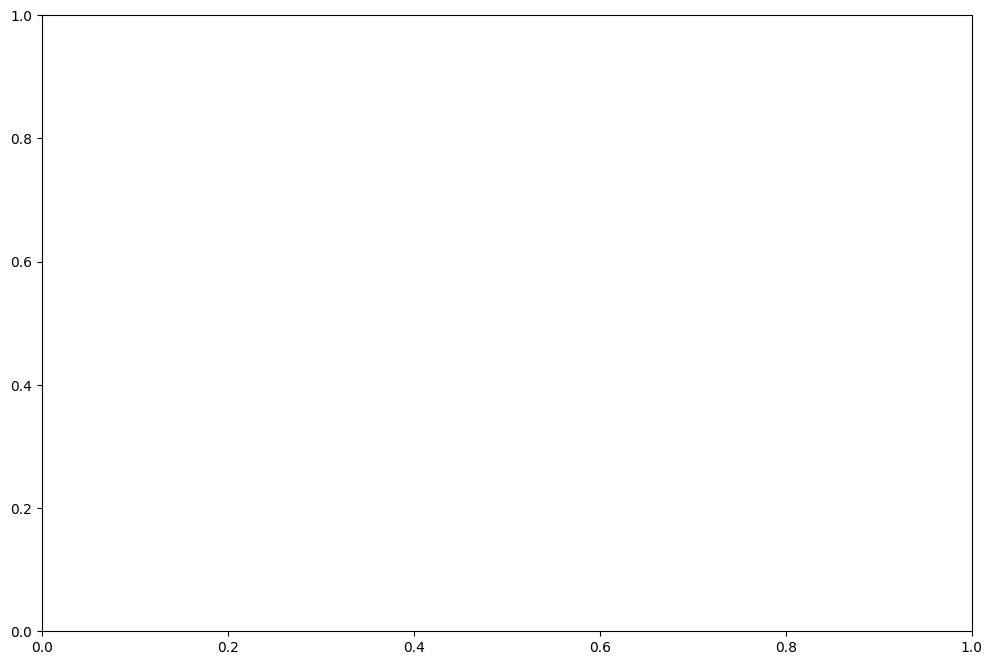

In [12]:
textgen_config = TextGenerationConfig(n=2, temperature=0.2, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

Recommended 1 charts


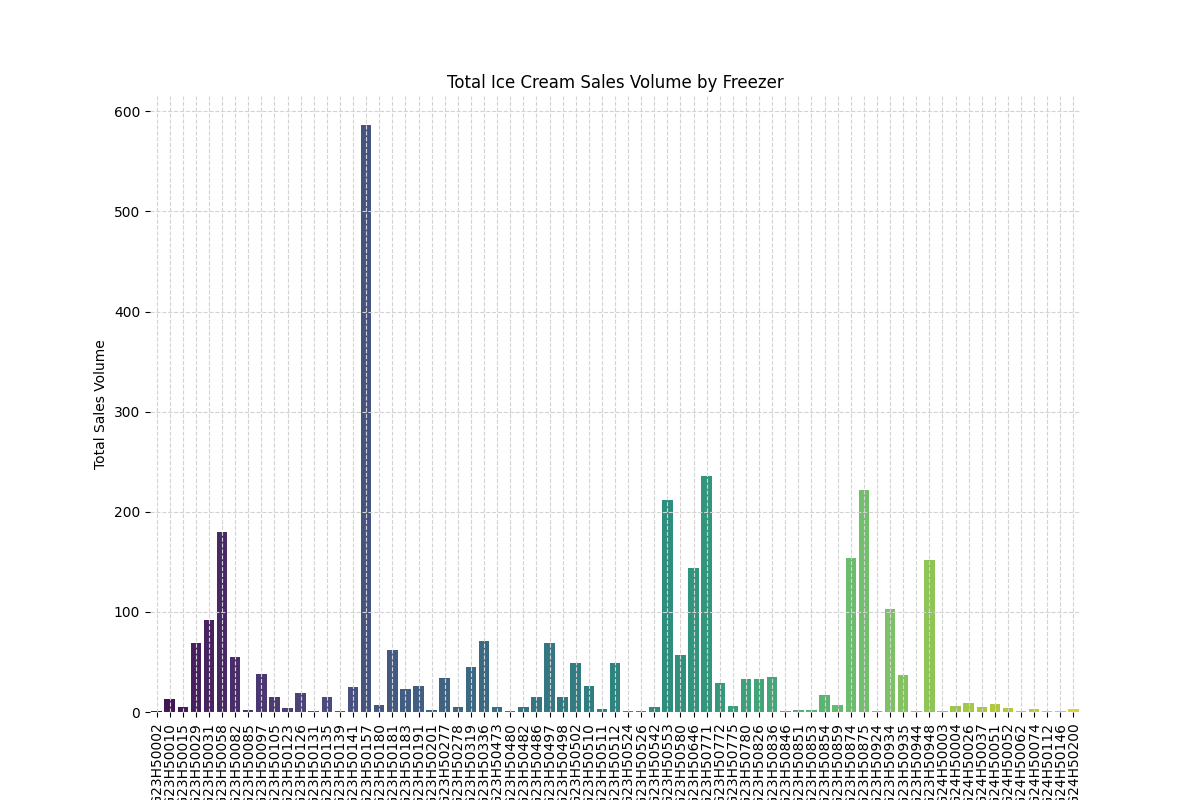

In [13]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    display(chart)

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization
- Uses the `peacasso` package, and loads open source stable diffusion models
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [ ]:
# !pip install lida[infographics]
# ensure you have a GPU runtime

In [15]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, green pearly rain drops, highly detailed, no blur, white background")

KeyboardInterrupt: 

In [ ]:
from lida.utils import plot_raster
plot_raster([edited_charts[0].raster, infographics["images"][0]])